In this notebook we prepare two new experiments -

1) In one we choose which TCGA-non-TGCT (from other TCGA studies) samples we will use for classification of TGCTs against non-TGCTs. We do so by age and gender (although the fact that other types of tissue are used is not accounted for). The idea of this is having a "specific" biomarker (perhaps some miRNAs are non-TGCT related, so it's important to compare against tumors of other origin).

2) A second experiment relates with only TCGA samples, but uses clinical stage

In [1]:
import pandas as pd

In [2]:
clin_data_url = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/sample_annotations/TCGA_all_studies_sample_clin_data.csv"
clin_data = pd.read_csv(clin_data_url, index_col=0)
TCGA_TGCT_sample_url = "https://raw.githubusercontent.com/Ignas12345/masters_project_data_and_notebooks/refs/heads/main/Data/sample_annotations/TCGA_TGCT_divisions_by_experiment.csv"
TCGA_TGCT_sample_info = pd.read_csv(TCGA_TGCT_sample_url, index_col=0)


In [3]:
TCGA_TGCT_samples = TCGA_TGCT_sample_info.index
#get only the first 12 characters:
TCGA_TGCT_samples_truncated = [sample[:12] for sample in TCGA_TGCT_samples]
TCGA_TGCT_clin_data = clin_data.loc[TCGA_TGCT_samples_truncated]

Prepare experiment according to clinical stage

In [24]:
#Prepare experiment according to clinical stage
division_by_stage = pd.DataFrame(index = TCGA_TGCT_samples)
label_dict = {}
for sample in TCGA_TGCT_samples:
  truncated_sample = sample[:12]
  if clin_data.loc[truncated_sample, 'ajcc_pathologic_stage'] in ['Stage I', 'Stage IA', 'Stage IB', 'Stage IS'] and clin_data.loc[truncated_sample,'site_of_resection_or_biopsy'] == 'Testis, NOS':
    label_dict[sample] = 'Stage I'
  elif clin_data.loc[truncated_sample, 'ajcc_pathologic_stage'] in ['Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC'] and clin_data.loc[truncated_sample,'site_of_resection_or_biopsy'] == 'Testis, NOS':
    label_dict[sample] = 'Stage II/III'
  else:
    label_dict[sample] = 'unused'
division_by_stage['Stage I vs Stage II/III'] = pd.Series(label_dict)
division_by_stage['Stage I vs Stage II/III'].value_counts()

,count
Stage I vs Stage II/III,
Stage I,107
Stage II/III,26
unused,4


In [5]:
division_by_stage

,Stage I vs Stage II/III
sample,
TCGA-2G-AAEW-01,Stage I
TCGA-2G-AAEX-01,Stage I
TCGA-2G-AAF1-01,Stage I
TCGA-2G-AAF4-01,Stage I
TCGA-2G-AAF6-01,Stage I
...,...
TCGA-ZM-AA0D-01,Stage I
TCGA-ZM-AA0E-01,Stage I
TCGA-ZM-AA0F-01,Stage I


In [6]:
division_by_stage.to_csv('division_by_stage.csv', sep = ';')

Now we pick the samples that we will combine with TCGA-TGCT samples

In [16]:
clin_data.columns

Index(['synchronous_malignancy', 'site_of_resection_or_biopsy', 'age_at_index',
       'days_to_birth', 'primary_diagnosis', 'prior_malignancy',
       'tissue_or_organ_of_origin', 'ajcc_pathologic_stage',
       'diagnosis_is_primary_disease', 'gender'],
      dtype='object')

In [35]:
clin_data_filtered = clin_data[clin_data['gender'] == 'male'].copy()
clin_data_filtered = clin_data_filtered[clin_data_filtered['tissue_or_organ_of_origin'] != 'Testis, NOS	'].copy()
clin_data_filtered = clin_data_filtered[clin_data_filtered['tissue_or_organ_of_origin'] != 'Testis, NOS'].copy()
clin_data_filtered = clin_data_filtered[~clin_data_filtered.index.isin(TCGA_TGCT_samples_truncated)].copy()

In [10]:
#ChatGPT funkcija kad atrinkti meginius pagal amziu
def add_age_bin(df):
    # Define age bins based on histogram intervals
    df = df.copy()
    age_bins = [14, 20, 30, 40, 50, 60, 70, 80]  # Adjust as needed
    age_labels = ["<20","20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]

    # Assign age bins to primary and secondary
    df["Age_Bin"] = pd.cut(df["age_at_index"], bins=age_bins, labels=age_labels, right=False)

    return df

In [8]:

import numpy as np
#Chat GPT funkcija - neįsivaizuoju kaip ji veikia. Na apskritai tas resampliavimas toks per daug "arbitrary", tai gal jį daryti ir nėra etiška
def max_resample_secondary_to_match_primary(primary_df, secondary_df, label_col):
    """
    Resamples secondary_df without replacement to maximize the sample size,
    while keeping the class distribution as close as possible to that of primary_df.

    Parameters:
    - primary_df: pd.DataFrame with reference class distribution.
    - secondary_df: pd.DataFrame to be sampled from.
    - label_col: str, name of class label column.

    Returns:
    - resampled_secondary_df: pd.DataFrame, resampled subset of secondary_df.
    """
    primary_df = primary_df.copy()
    secondary_df = secondary_df.copy()
    # 1. Calculate primary distribution proportions
    primary_props = primary_df[label_col].value_counts(normalize=True)

    # 2. Calculate available counts per class in secondary
    secondary_counts = secondary_df[label_col].value_counts()

    # 3. For each class, calculate max multiplier = available_samples / class proportion
    max_multipliers = []

    for label, prop in primary_props.items():
        if prop == 0:
            # If class proportion is zero, ignore (or treat carefully)
            max_multipliers.append(np.inf)
            continue

        avail = secondary_counts.get(label, 0)
        if avail == 0:
            # No samples of this class in secondary; max multiplier = 0
            max_multipliers.append(0)
        else:
            max_multipliers.append(avail / prop)

    # 4. The max possible multiplier without distorting distribution
    max_multiplier = min(max_multipliers)

    # To avoid floating rounding errors, round down
    max_multiplier = int(np.floor(max_multiplier))

    # 5. Calculate samples per class from secondary using max_multiplier
    sampled_dfs = []
    for label, prop in primary_props.items():
        n_samples = int(np.floor(prop * max_multiplier))
        subset = secondary_df[secondary_df[label_col] == label]

        # Safety check, in case of rounding issues
        n_samples = min(n_samples, len(subset))

        sampled_subset = subset.sample(n=n_samples, replace=False, random_state=42)
        sampled_dfs.append(sampled_subset)

    # 6. Combine and shuffle the sampled data
    resampled_secondary_df = pd.concat(sampled_dfs).sample(frac=1, random_state=42).reset_index(drop=False)

    return resampled_secondary_df


In [38]:
primary_df = add_age_bin(clin_data.loc[TCGA_TGCT_samples_truncated])
secondary_df = add_age_bin(clin_data_filtered)
resampled_clin_data = max_resample_secondary_to_match_primary(primary_df, secondary_df, label_col = 'Age_Bin')
resampled_clin_data.set_index('submitter_id', inplace=True)

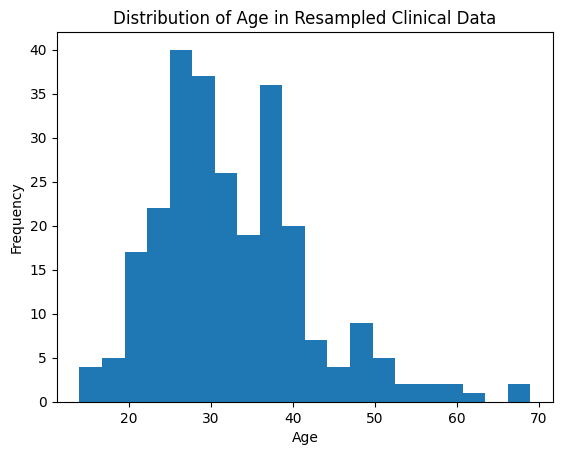

In [39]:
import matplotlib.pyplot as plt

plt.hist(resampled_clin_data['age_at_index'].dropna(), bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Resampled Clinical Data')
plt.show()

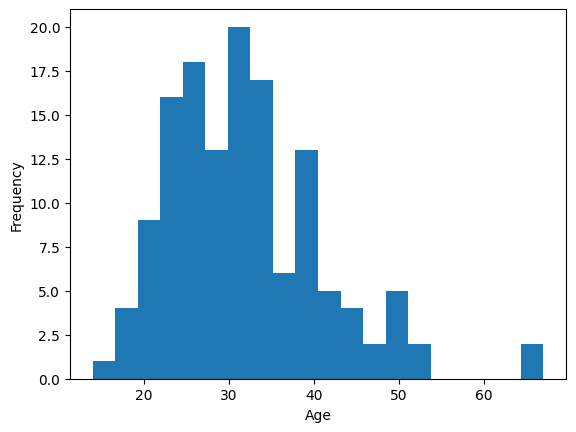

In [32]:
import matplotlib.pyplot as plt

plt.hist(clin_data.loc[TCGA_TGCT_samples_truncated,'age_at_index'].dropna(), bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [40]:
resampled_clin_data

,synchronous_malignancy,site_of_resection_or_biopsy,age_at_index,days_to_birth,primary_diagnosis,prior_malignancy,tissue_or_organ_of_origin,ajcc_pathologic_stage,diagnosis_is_primary_disease,gender,Age_Bin
submitter_id,,,,,,,,,,,
TCGA-W3-AA21,No,Not Reported,26.0,-9527.0,"Malignant melanoma, NOS",no,"Skin, NOS",Stage I,False,male,20-29
TCGA-AS-3778,No,"Kidney, NOS",35.0,-12937.0,"Clear cell adenocarcinoma, NOS",no,"Kidney, NOS",Stage I,True,male,30-39
TCGA-IK-7675,No,"Nervous system, NOS",43.0,-15900.0,"Oligodendroglioma, NOS",no,Cerebrum,NaN,True,male,40-49
TCGA-ET-A39M,No,Thyroid gland,34.0,-12441.0,"Papillary adenocarcinoma, NOS",no,Thyroid gland,Stage I,True,male,30-39
TCGA-26-1438,Not Reported,"Brain, NOS",36.0,-13489.0,Glioblastoma,not reported,"Brain, NOS",NaN,True,male,30-39
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-FG-7634,No,"Nervous system, NOS",28.0,-10476.0,"Oligodendroglioma, NOS",no,Cerebrum,NaN,True,male,20-29
TCGA-DU-A7TA,No,"Nervous system, NOS",32.0,-11764.0,"Oligodendroglioma, NOS",no,Cerebrum,NaN,True,male,30-39
TCGA-WB-A80P,No,Retroperitoneum,20.0,-7608.0,"Extra-adrenal paraganglioma, malignant",no,Retroperitoneum,NaN,True,male,20-29


In [41]:
resampled_clin_data.to_csv('filtered_other_tcga_patients.csv', sep = ';')

In [42]:
TCGA_TGCT_clin_data.to_csv('TCGA_TGCT_clin_data.csv', sep = ';')